<h1 style="font-size:30px;">Image Classification Using Transfer Learning with Torchvision</h1>  

In this notebook, we will learn how to train an Image Classifier on the **Caltech-256** dataset subset provided by using a pretrained model. We will use the **ResNet-50** network architecture but we instantiate the convolutional base of the network with weights that have been pre-trained on the ImageNet dataset.

`We will add our own classification layer and only train the classifier part of the network. This technique is called transfer learning.`

Finally we  will demonstrate that using a pre-trained convolutional base results in a tremendous jump in the performance metrics with literally no effort.

## Table of Contents

* [1. Overview of Pre-Trained Model Use Cases](#1.-Overview-of-Pre-Trained-Model-Use-Cases)
* [2. Download and Extract the Caltech256 Subset Dataset](#2.-Download-and-Extract-the-Caltech256-Subset-Dataset)
* [3. DataLoader Preparation](#3.-DataLoader-Preparation)
* [4. Load the ResNet50 Pre-Trained Model](#4.-Load-the-ResNet50-Pre-Trained-Model)
* [5. Model Training](#5.-Model-Training)
* [6. Inference](#6.-Inference)
* [7. Conclusion](#7.-Conclusion)

## 1. Overview of Pre-Trained Model Use Cases

A typical image classification architecture consists of 4 parts:-
1.   Input image
2.   Feature Extractor - a bank of convolutional layers that extract useful features for classification.
3.   Classifier - a bank of fully connected layers that classify the image into its output classes.  
4.   Output vector of class probabilities

<img src=https://learnopencv.com/wp-content/uploads/2024/07/Transfer-learning.png align='center'><br/>

Before we proceed with the coding implementation for Transfer Learning, it's helpful to review the table below, which summarizes several use cases.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-training-methods.png width=850 align='center'><br/>

### 1.1. Pre-Trained ImageNet Models

- no training is required; you can simply load the model and make predictions on your pre-processed input images.
- There are many pre-trained models available in Torchvision, which you can select from.
- For situations where your application contains specific classes that are not contained in ImageNet we can perform finetuning by unfreezing several conv layers to adapt to new features.


### 1.2. Train from Scratch
- If you need to customize a model for a new dataset, one option is to load a model and train it from scratch.
- When training from scratch, the entire model is initialized with random weights, and training is performed from scratch (with the predefined classifier).
- Training a model from scratch requires a lot of data and a lot of computational resources, although this depends on the size of the model. Still, it's a significant factor to consider, especially if you don't have much data and acquiring labeled training data for your application is difficult.
- Better options exist, but for reference, we trained the custom model from scratch in one of our previous post trained on 10 Monkey Species Dataset.

### 1.3. Transfer Learning

- Simple approach for re-purposing a pre-trained model to make predictions on a new dataset.
- The concept is simple. We use the model's pre-trained feature extractor (convolutional base) and re-train a new classifier to learn new weights for the new dataset.
- This is sometimes referred to as "`freezing`" the layers in the feature extractor, meaning that we load the pre-trained weights and do not attempt to modify them further during the training process. 
- The theory is that the pre-trained ImageNet Feature Extractor has learned valuable features for detecting many different object types. 
- We assume such features are general enough that we only need to re-train the classifier portion of the network.

- Requires much less data and computational resources than training from scratch.
- Remember that training a model often takes many iterations to determine an appropriate set of hyper-parameters for a final model, so the time required to experiment and iterate will be significantly compounded. 
- Since pre-trained models were trained on millions of images, it behooves us to try and leverage that inherent capability. 
- Transfer learning allows you to quickly study how a pre-trained model can be customized for a new dataset. However, sometimes retraining the classifier isn't enough. This is where Fine-Tuning can be very beneficial.

### 1.4. Fine Tuning

- Fine-Tuning represents a flexible alternative to Transfer Learning. It is very similar to Transfer Learning. 
- Instead of locking down the feature extractor completely, we load the feature extractor with ImageNet weights and then `freeze the first several layers of the feature extractor but allow the last few layers to be trained further`. 
- The idea is that the first several layers in the feature extractor represent generic, low-level features (e.g., edges, corners, and arcs) that are fundamental building blocks necessary to support many classification tasks.
- Subsequent layers in the feature extractor build upon the lower-level features to learn more complex representations that are more closely related to the content of a particular dataset.


- With Fine-Tuning, we can specifically leverage the lower-level features of the pre-trained model but provide some flexibility for "fine-tuning" the last few layers of the convolutional base to provide the best possible customization for the dataset.
- So we "freeze" the initial layers (i.e., make them non-trainable) and let the model train the last few layers of the feature extractor, as well as the classifier. 
- Note that all the layers in the feature extractor are initialized to ImageNet weights. Once training begins, the weights in the last few layers of the feature extractor are updated further, which is why this approach is called Fine-Tuning. Also, the weights in the classifier are initialized to small random values since we want the classifier to learn new weights required to classify new content.

### Import Dependencies

In [1]:
# !pip install torchinfo -q
# !pip install pandas

In [2]:
import torch  # for deep learning computations
import torchvision  # for pre-trained models and datasets
import torch.nn as nn  # Import neural network module from PyTorch
import torch.optim as optim  # Import optimizers for training models
import time  # for measuring execution time
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for visualization
import os  # for file system operations
import zipfile  # for extracting compressed datasets
import requests  # for downloading files

import pandas as pd  # for data manipulation and analysis
from PIL import Image  # for image processing

from torchvision import datasets, models, transforms
from torchinfo import summary  # for displaying model summaries

# for handling batch data loading
from torch.utils.data import DataLoader

# Set the Matplotlib style to 'ggplot' for better visuals
plt.style.use('ggplot')

### 2. Download and Extract the Caltech256 Subset Dataset

In [3]:
# Helper function to download file.
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)


# Download the dataset.
download_file(
    'https://www.dropbox.com/s/0ltu2bsja3sb2j4/caltech256_subset.zip?dl=1',
    'caltech256_subset.zip'
)

# Extract the dataset.
file = 'caltech256_subset.zip'
with zipfile.ZipFile(file, 'r') as zip:
    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

extraction...
Done!


### 3. DataLoader Preparation

The dataset we will be using here is a subset of Caltech256 dataset
 containing 10 categories and number of samples as follows:
 
|     Class     | Train Samples | Valid Samples | Test Samples |
|:-------------:|:-------------:|:-------------:|:------------:|
|      bear     |       60      |       10      |      10      |
|     chimp     |       60      |       10      |      10      |
|    giraffe    |       60      |       10      |      10      |
|    gorilla    |       60      |       10      |      10      |
|     llama     |       60      |       10      |      10      |
|    ostrich    |       60      |       10      |      10      |
|   porcupine   |       60      |       10      |      10      |
|     skunk     |       60      |       10      |      10      |
| triceratops   |       60      |       10      |      10      |
|     zebra     |       60      |       10      |      10      |


### 3.1. Preprocessing Transforms

In [4]:
# Defining transformations to be applied to training, validation, and test datasets
image_transforms = {
    'train': transforms.Compose([
        # Randomly crop the image with scaling
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # Apply random rotation up to 15 degrees
        transforms.RandomRotation(degrees=15),
        # Flip the image horizontally with a probability of 0.5
        transforms.RandomHorizontalFlip(),
        # Crop the center of the image to 224x224 pixels
        transforms.CenterCrop(size=224),
        # Convert image to PyTorch tensor format
        transforms.ToTensor(),
        # Normalize image using mean and standard deviation
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),


    'valid': transforms.Compose([
        # Resize the image to 256 pixels on the shorter side
        transforms.Resize(size=256),
        # Crop the center of the image to 224x224 pixels
        transforms.CenterCrop(size=224),
        # Convert image to PyTorch tensor format
        transforms.ToTensor(),
        # Normalize image using mean and std
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        ]),


    'test': transforms.Compose([
        # Resize the image to 256 pixels on the shorter side
        transforms.Resize(size=256),
        # Crop the center of the image to 224x224 pixels
        transforms.CenterCrop(size=224),
        # Convert image to PyTorch tensor format
        transforms.ToTensor(),
        # Normalize image using mean and std
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])
}

### 3.2. Dataset Preparation

In [5]:
# Load the dataset
# Set the train, valid and test directory paths
dataset = 'caltech256_subset'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

In [6]:
# Define batch size and number of classes
batch_size = 32
num_classes = len(os.listdir(valid_directory))
print(num_classes)

10


In [7]:
# load data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v:k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [8]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device used -> {device}")
print(f"Number of training samples:   {train_data_size}")
print(f"Number of validation samples: {valid_data_size}"),
print(f"Number of test samples:       {test_data_size}")

Device used -> cpu
Number of training samples:   600
Number of validation samples: 100
Number of test samples:       100


### 4. Load the **ResNet50** Pre-Trained Model

In [10]:
resnet50 = models.resnet50(weights='DEFAULT')
resnet50 = resnet50.to(device)

### 4.1. Set all the layers to be freezed initially

By setting the `param.requires_grad = False` we ensure that all the model weights for those layers are freezed.

In [11]:
# Freezq Model Parameters
for param in resnet50.parameters():
    param.requires_grad=False

In [12]:
num_classes

10

### 4.2. Unfreeze the final layer of the classifier's head

As our dataset contains just 10 classes we have to modify the model's final layer from IMAGENET 1000 classes to match the num of classes of the subset dataset.

In [13]:
# Change the final fully connected layer of the ResNet50 model for transfer learning

# 1. Get the number of input features for the final layer
fc_inputs = resnet50.fc.in_features

# 2. Define a new fully connected layer with custom architecture for classification
resnet50.fc = nn.Sequential(
    # Fully connected layer with 256 neurons
    nn.Linear(fc_inputs, 256),
    # Apply ReLU activation
    nn.ReLU(),
    # Apply dropout with 40% probability to prevent overfitting
    nn.Dropout(0.4),
    # Output layer with number of classes as output neurons
    nn.Linear(256, num_classes),

    # for multi-class classification (used with NLLLoss)
    nn.LogSoftmax(dim=1)
)

# Move the model to the appropriate device (either CUDA or CPU)
resnet50 = resnet50.to(device)

resnet50.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

### 4.3. Training Configuration


In [14]:
# 1. Define the loss function for classification
loss_function = nn.NLLLoss()    # Suitable for Multi-class Classification

# 2. Define the learning rate for the optimizer
learning_rate = 0.01

# 3. Define the optimizer using Stochastic Gradient Descent (SGD)
optimizer = optim.SGD(
    params=resnet50.parameters(),   # Optimizing all parameters of the ResNet50 model
    lr=learning_rate,
    momentum=0.9    # to improve convergence and avoid local minima
)

### 5. Model Training

In [21]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    """
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    """

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # 1. Set to training mode
        model.train()

        # 2. Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Clean existing gradients
            optimizer.zero_grad()

            # 2. Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # 3. Compute loss
            loss = loss_criterion(outputs, labels)

            # 4. Backpropagate the gradients
            loss.backward()

            # 5. Update the parameters
            optimizer.step()

            # 6. Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # 7. Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # 8. Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # 9. Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            print("Batch number: {:03d}, Training Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Validation - No gradient tracking needed
        with torch.no_grad():

            # 1. Set to evaluation mode
            model.eval()

            # 2. Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 1. Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # 2. Compute loss
                loss = loss_criterion(outputs, labels)

                # 3. Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # 4. Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # 5. Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # 6. Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            # Save if the model has best accuracy till now
            torch.save(model, 'best_model.pt')

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(
            epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    return model, history, best_epoch

In [22]:
# Print the model to be trained.
print(summary(resnet50, input_size=(batch_size, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [23]:
# Train the Model
num_epochs = 25
trained_model, history, best_epoch =train_and_validate(resnet50, loss_function, optimizer, num_epochs)

# Save the History
torch.save(history, dataset+'_history.pt')

Epoch: 1/25
Batch number: 000, Training Loss: 1.9826, Accuracy: 0.7812
Batch number: 001, Training Loss: 1.9299, Accuracy: 0.8750
Batch number: 002, Training Loss: 1.9421, Accuracy: 0.8125
Batch number: 003, Training Loss: 1.8836, Accuracy: 0.9062
Batch number: 004, Training Loss: 1.8548, Accuracy: 0.8750
Batch number: 005, Training Loss: 1.8097, Accuracy: 0.9688
Batch number: 006, Training Loss: 1.8117, Accuracy: 0.8438
Batch number: 007, Training Loss: 1.7176, Accuracy: 0.7812
Batch number: 008, Training Loss: 1.7488, Accuracy: 0.7812
Batch number: 009, Training Loss: 1.6653, Accuracy: 0.8125
Batch number: 010, Training Loss: 1.5489, Accuracy: 0.9375
Batch number: 011, Training Loss: 1.6558, Accuracy: 0.8750
Batch number: 012, Training Loss: 1.5335, Accuracy: 0.9062
Batch number: 013, Training Loss: 1.3864, Accuracy: 0.9375
Batch number: 014, Training Loss: 1.6180, Accuracy: 0.7188
Batch number: 015, Training Loss: 1.3392, Accuracy: 0.9062
Batch number: 016, Training Loss: 1.2848, Ac

### 5.1. Plotting the Training Logs

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 2, 4)

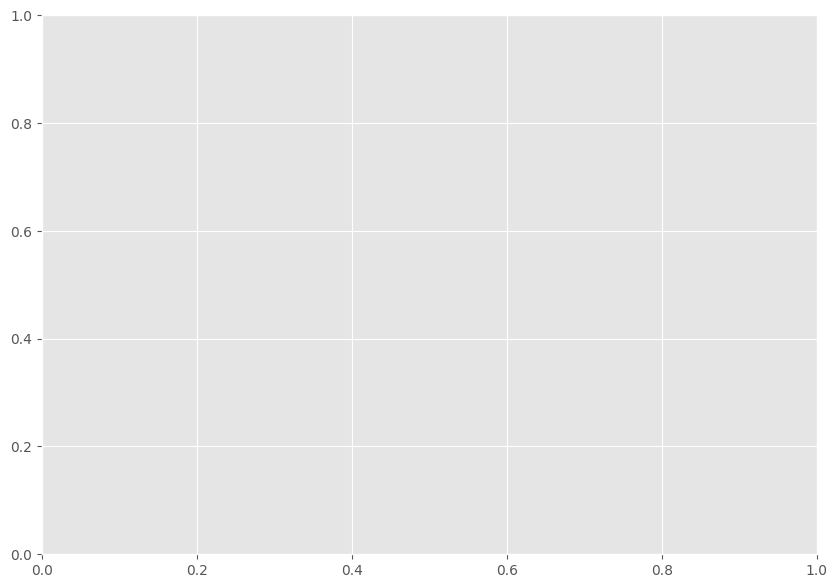

In [24]:
history = np.array([history])

plt.figure(figsize=(10, 7))
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history[:, 0:2])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()

Let's define a custom evaluation function that calculates the accuracy metric of our trained model on the test dataset.

In [ ]:
def computeTestSetAccuracy(model, loss_criterion):
    """
    Computes the accuracy and loss of the model on the test dataset.

    Parameters:
    model (torch.nn.Module): The trained model to evaluate.
    loss_criterion (torch.nn.Module): The loss function used for evaluation.

    The function runs inference on the test dataset without tracking gradients,
    calculates the loss and accuracy for each batch, and returns the average loss and accuracy.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():
        # 1. Set to evaluation mode
        model.eval()

        # 2. Testing loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 1. Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # 2. Compute loss
            loss = loss_criterion(outputs, labels)

            # 3. Compute the total loss for the batch and add it to test_loss
            test_loss += loss.item() * inputs.size(0)

            # 4. Calculate test accuracy
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # 5. Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # 6. Compute total accuracy in the whole batch and add to test_acc
            test_acc += acc.item() * inputs.size(0)

            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    # Find average test loss and test accuracy
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy: {:.4f}".format(avg_test_acc))
    print("Test loss: {:.4f}".format(avg_test_loss))

In [ ]:
# Load the best saved model during training.
model = torch.load("best_model.pt".format(dataset, best_epoch), weights_only=False)

# Evaluate the model's performance on the test dataset and print the results.
computeTestSetAccuracy()

### 6. Inference

In [ ]:
def predict(model, test_image_name):
    """
    Predicts the class of a given test image using a trained model.

    Parameters:
    model (torch.nn.Module): The trained model to use for prediction.
    test_image_name (str): The file path of the test image.

    The function loads the image, applies necessary transformations, and
    passes it through the model to get the top 3 predictions with their confidence scores.
    """
    # 1. Applies the predefined transformation pipeline for test images
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)

    # 2. Creates a figure to visualize the test image
    plt.figure(figsize=(10, 7))
    # 3. Displays the test image before applying transformations
    plt.imshow(test_image)
    plt.axis('off')  # Removes the axis for a cleaner image visualization

    # 4. Apply transformations and reshape to fit model input
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(
        1, 3, 224, 224)  # Reshape for batch processing

    # 5. Checks if a GPU is available and moves the tensor to CUDA if possible
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.cuda()

    with torch.no_grad():  # Disables gradient computation to optimize inference performance
        model.eval()  # Set model to evaluation mode
        out = model(test_image_tensor)  # Get model predictions
        # Convert log probabilities to actual probabilities
        ps = torch.exp(out)

        # Extract the top 3 predictions and their probabilities
        topk, topclass = ps.topk(3, dim=1)
        # Get the top predicted class
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        # Get the top prediction confidence score
        score = topk.cpu().numpy()[0][0]

        # Print the top 3 predictions with their confidence scores
        for i in range(3):
            print(f"Prediction {i+1}: {idx_to_class[topclass.cpu().numpy()[0][i]]}",f"Score: {topk.cpu().numpy()[0][i]*100:.3f}%")

In [ ]:
from urllib.parse import urlparse

urls = [
    "https://learnopencv.com/wp-content/uploads/2022/10/skunk.jpg",
    "https://learnopencv.com/wp-content/uploads/2024/02/Zebra.jpg",
    "https://learnopencv.com/wp-content/uploads/2024/07/llama-scaled.jpg",
    "https://learnopencv.com/wp-content/uploads/2024/07/llama_-scaled.jpg"
]


for url in urls:
    response = requests.get(url, timeout=10)

    if response.status_code == 200:
        filename = os.path.basename(urlparse(url).path)
        with open(f"images/{filename}", "wb") as f:
            f.write(response.content)
        print(f"Downloaded: {filename} ✅")

In [ ]:
predict(model, 'skunk.jpg')

In [ ]:
predict(model, 'Zebra.jpg')

In [ ]:
predict(model, 'llama.jpg')

In [ ]:
predict(model, 'llama_.jpg')

- `Fine-tuning pre-trained models` is a powerful technique that allows you to `re-purpose a model for a custom dataset`.

- Torchvision comes bundled with many pre-trained classification models, allowing you to conveniently load a model in memory and configure it for Fine-Tuning. Let's summarize the key steps required for fine-tuning a pre-trained model.

- When fine-tuning pre-trained models, we only load the convolutional base of the model, which is initialized with ImageNet weights.  
- We "freeze" the first few layers of the convolutional base but allow the last few layers to be trained ("fine-tuned").
- These steps are accomplished with the `param.requires_grad` to toggle which layers are trainable and which are not
-. The number of layers to fine-tune is something you need to experiment with. 
- The classifier needs to be redefined based on the dataset and is initialized with random weights. 
- In this way, the model's initial state is in a favorable position for continued learning that allows it to adapt to a new dataset and learn faster (and potentially better) than training a model from scratch. 
- This approach also allows the model to be re-purposed for a new dataset with much less data than would be required for training a model from scratch.